In [12]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Libraries re-imported successfully.")

Libraries re-imported successfully.


In [1]:
import os
import glob

BASE_DIR = '/content/drive/MyDrive/Crack_500_Dataset'
# Pointing both to the folder you just showed me
TARGET_DIR = os.path.join(BASE_DIR, 'traincrop', 'traincrop')

print(f"Checking folder: {TARGET_DIR}")

# Get all files
all_files = os.listdir(TARGET_DIR)
jpg_files = [f for f in all_files if f.endswith('.jpg')]
png_files = [f for f in all_files if f.endswith('.png')]

print(f"Found {len(jpg_files)} JPG files (Images)")
print(f"Found {len(png_files)} PNG files (Potential Masks)")

if len(png_files) > 0:
    print("\nSUCCESS! Masks are mixed in the same folder.")
    print("Sample PNGs:", png_files[:3])
    print("\n>>> FIX: Set TRAIN_MASK_DIR to the same path as TRAIN_IMG_DIR in Cell 3.")
else:
    print("\n❌ No masks found in this folder. You need to find the 'trainmask' folder in your Drive.")

Checking folder: /content/drive/MyDrive/Crack_500_Dataset/traincrop/traincrop
Found 1896 JPG files (Images)
Found 1896 PNG files (Potential Masks)

SUCCESS! Masks are mixed in the same folder.
Sample PNGs: ['20160328_154011_1_1081.png', '20160328_154017_1281_1.png', '20160328_153915_1281_361.png']

>>> FIX: Set TRAIN_MASK_DIR to the same path as TRAIN_IMG_DIR in Cell 3.


In [2]:
import os
# Define the directory that contains BOTH images and masks
TARGET_DIR = '/content/drive/MyDrive/Crack_500_Dataset/traincrop/traincrop'

# Count them separately by extension
jpgs = len([f for f in os.listdir(TARGET_DIR) if f.endswith('.jpg')])
pngs = len([f for f in os.listdir(TARGET_DIR) if f.endswith('.png')])

print(f"Folder: {TARGET_DIR}")
print(f"Training Images (.jpg): {jpgs}")
print(f"Training Masks  (.png): {pngs}")
print("-" * 30)
print(f"Total Files: {jpgs + pngs}")

if jpgs == pngs and jpgs > 0:
    print("\n✅ PERFECT MATCH! You have exactly one mask for every image.")
else:
    print("\n⚠️ Mismatch detected. You might have some orphaned files.")

Folder: /content/drive/MyDrive/Crack_500_Dataset/traincrop/traincrop
Training Images (.jpg): 1896
Training Masks  (.png): 1896
------------------------------
Total Files: 3792

✅ PERFECT MATCH! You have exactly one mask for every image.


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

print("Dependencies installed and Drive mounted!")

Dependencies installed and Drive mounted!


In [6]:
# Cell 3: Paths and Constants
import os
import glob

BASE_DIR = '/content/drive/MyDrive/Crack_500_Dataset'

# --- UPDATED: Pointing Image and Mask to the SAME folders ---
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'traincrop', 'traincrop')
TRAIN_MASK_DIR = os.path.join(BASE_DIR, 'traincrop', 'traincrop')

# Assuming Validation and Test follow the same pattern (images and masks mixed)
VAL_IMG_DIR = os.path.join(BASE_DIR, 'valcrop', 'valcrop')
VAL_MASK_DIR = os.path.join(BASE_DIR, 'valcrop', 'valcrop')

TEST_IMG_DIR = os.path.join(BASE_DIR, 'testcrop', 'testcrop')
TEST_MASK_DIR = os.path.join(BASE_DIR, 'testcrop', 'testcrop')
# ------------------------------------------------------------

IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8

print(f"Raw Train images: {len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))}")
print(f"Raw Val images: {len(glob.glob(os.path.join(VAL_IMG_DIR, '*.jpg')))}")

Raw Train images: 1896
Raw Val images: 348


In [8]:
# Cell 4: Data Loading and Generator (STRICT Matching for Mixed Folders)
def load_image(img_path, mask_path=None, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load and preprocess image and optional mask."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # To RGB
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0

    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to load mask: {mask_path}")
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.float32)  # Binary
        return img, mask
    return img

def get_data_paths(img_dir, mask_dir):
    """
    STRICT matching for folders where images and masks are mixed.
    Assumes: Images are .jpg, Masks are .png
    """
    # 1. STRICT loads: ONLY .jpg for images, ONLY .png for masks
    img_paths = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))

    if not img_paths or not mask_paths:
        # Warning if empty, but continue so other dirs might work
        print(f"Warning: No data found in {img_dir} (looking for .jpg images and .png masks)")
        return []

    # 2. Map basename (without extension) to full path
    img_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in img_paths}
    mask_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in mask_paths}

    # 3. Find common keys (files that have BOTH a .jpg and .png version)
    common_bases = sorted(set(img_dict.keys()) & set(mask_dict.keys()))

    # 4. Create pairs
    paired = []
    for base in common_bases:
        paired.append((img_dict[base], mask_dict[base]))

    print(f"Loaded {len(paired)} pairs from {os.path.basename(img_dir)}")
    # Optional: print first pair to verify
    # if len(paired) > 0:
    #     print(f"Sample: {os.path.basename(paired[0][0])} | {os.path.basename(paired[0][1])}")
    return paired

# Load paths
print("--- Loading Training Data ---")
train_paths = get_data_paths(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
print("\n--- Loading Validation Data ---")
val_paths = get_data_paths(VAL_IMG_DIR, VAL_MASK_DIR)
print("\n--- Loading Test Data ---")
test_paths = get_data_paths(TEST_IMG_DIR, TEST_MASK_DIR)

# Generator (Unchanged)
def data_generator(paths, batch_size=BATCH_SIZE, augment=False):
    while True:
        np.random.shuffle(paths)
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_imgs = []
            batch_masks = []
            for img_p, mask_p in batch_paths:
                img, mask = load_image(img_p, mask_p)
                batch_imgs.append(img)
                batch_masks.append(mask)

            batch_imgs = np.array(batch_imgs)
            batch_masks = np.expand_dims(np.array(batch_masks), -1)

            if augment:
                datagen = ImageDataGenerator(
                    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
                    zoom_range=0.1, horizontal_flip=True, fill_mode='reflect'
                )
                seed = np.random.randint(0, 10000)
                img_gen = datagen.flow(batch_imgs, batch_size=len(batch_imgs), seed=seed, shuffle=False)
                mask_gen = datagen.flow(batch_masks, batch_size=len(batch_masks), seed=seed, shuffle=False)
                batch_imgs = next(img_gen)
                batch_masks = next(mask_gen)
                batch_masks = (batch_masks > 0.5).astype(np.float32)

            yield batch_imgs, batch_masks

# Steps
train_steps = (len(train_paths) + BATCH_SIZE - 1) // BATCH_SIZE
val_steps = (len(val_paths) + BATCH_SIZE - 1) // BATCH_SIZE
test_steps = (len(test_paths) + BATCH_SIZE - 1) // BATCH_SIZE

print(f"\nTrain: {len(train_paths)} samples, {train_steps} steps")
print(f"Val: {len(val_paths)} samples, {val_steps} steps")
print(f"Test: {len(test_paths)} samples, {test_steps} steps")
print("Generators ready!")

--- Loading Training Data ---
Loaded 1896 pairs from traincrop

--- Loading Validation Data ---
Loaded 348 pairs from valcrop

--- Loading Test Data ---
Loaded 1121 pairs from testcrop

Train: 1896 samples, 237 steps
Val: 348 samples, 44 steps
Test: 1121 samples, 141 steps
Generators ready!


In [14]:
# Cell 5: U-Net Model (with Robust Checkpointing)
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Loss Functions ---
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# --- U-Net Architecture ---
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)
    # Decoder
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)
    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)
    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)
    return Model(inputs, outputs)

# --- Build and Compile ---
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=['accuracy', MeanIoU(num_classes=2, name='iou')])

# --- IMPROVED CALLBACKS ---
checkpoint_best = ModelCheckpoint('/content/drive/MyDrive/unet_best.keras', save_best_only=True, monitor='val_loss', verbose=1)
checkpoint_latest = ModelCheckpoint('/content/drive/MyDrive/unet_latest.keras', save_best_only=False, verbose=0) # Saves every epoch
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

print("Model compiled with robust checkpointing.")

Model compiled with robust checkpointing.


Starting training for 10 epochs...
Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9193 - iou: 0.4673 - loss: 1.0420
Epoch 1: val_loss improved from inf to 0.43018, saving model to /content/drive/MyDrive/unet_best.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1618s 7s/step - accuracy: 0.9194 - iou: 0.4673 - loss: 1.0409 - val_accuracy: 0.9692 - val_iou: 0.4715 - val_loss: 0.4302 - learning_rate: 1.0000e-04
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9605 - iou: 0.4681 - loss: 0.4960
Epoch 2: val_loss improved from 0.43018 to 0.41771, saving model to /content/drive/MyDrive/unet_best.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 124s 521ms/step - accuracy: 0.9605 - iou: 0.4681 - loss: 0.4960 - val_accuracy: 0.9691 - val_iou: 0.4714 - val_loss: 0.4177 - learning_rate: 1.0000e-04
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9617 - iou: 0.4679 - loss: 0.4677
Epoch 3: val_loss improved from 0.41771 to 0.35504, saving model to /content/drive/MyDrive/u

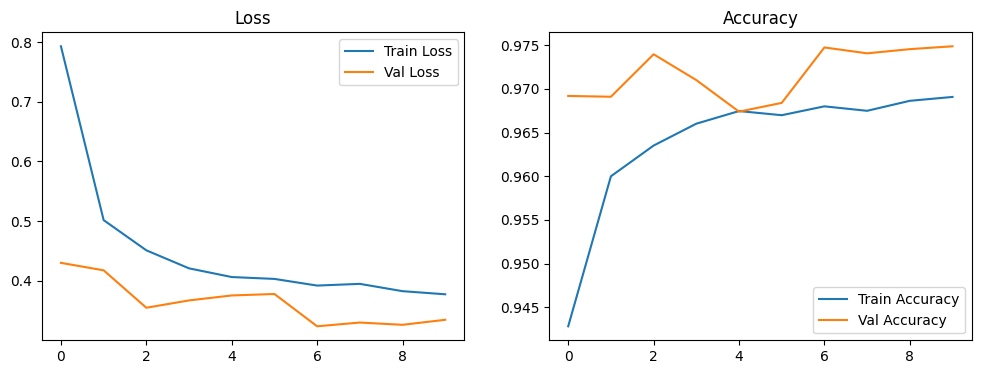

In [15]:
# Cell 6: Train Model (First 10 Epochs)
import matplotlib.pyplot as plt

EPOCHS = 10  # Set to 10 as requested

# Optional: If resuming after a crash, uncomment the next line:
# model.load_weights('/content/drive/MyDrive/unet_latest.keras')

print(f"Starting training for {EPOCHS} epochs...")
history = model.fit(
    data_generator(train_paths, augment=True),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=data_generator(val_paths, augment=False),
    validation_steps=val_steps,
    callbacks=[checkpoint_best, checkpoint_latest, early_stop, reduce_lr]
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(), plt.title('Accuracy')
plt.show()

--- Evaluating on Test Data ---
141/141 ━━━━━━━━━━━━━━━━━━━━ 885s 6s/step - accuracy: 0.9669 - iou: 0.4739 - loss: 0.4324

Test Results:
Loss: 0.4253 | Accuracy: 0.9657 | Mean IoU: 0.4721


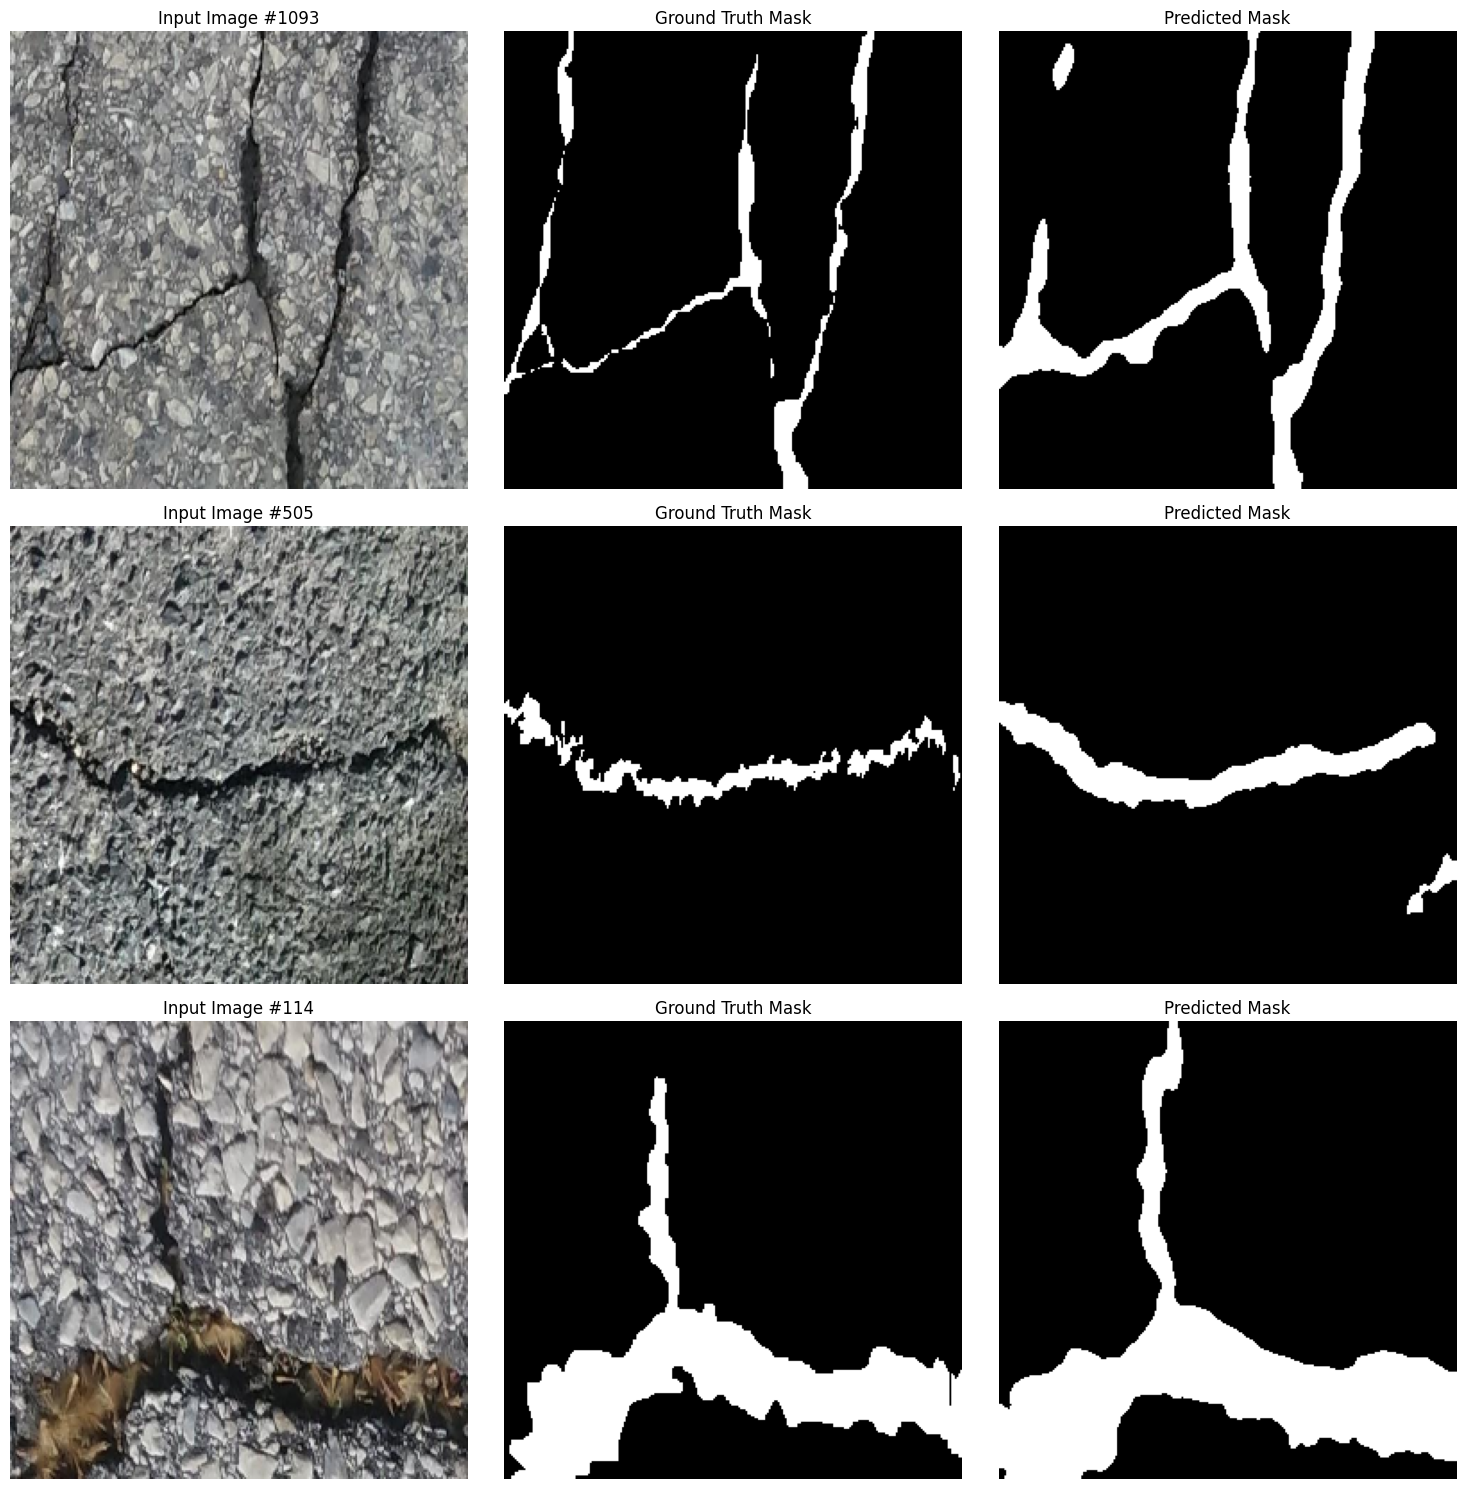


Final model saved to: /content/drive/MyDrive/unet_crack500_final.keras


In [16]:
# Cell 7: Evaluate and Visualize Results
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. Final Evaluation on Test Set
if len(test_paths) > 0:
    print("--- Evaluating on Test Data ---")
    test_loss, test_acc, test_iou = model.evaluate(
        data_generator(test_paths, augment=False),
        steps=test_steps,
        verbose=1
    )
    print(f"\nTest Results:\nLoss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | Mean IoU: {test_iou:.4f}")

    # 2. Visualize Multiple Samples (e.g., 3 random images)
    num_samples = 3
    # Pick random indices to check different images each time
    sample_indices = random.sample(range(len(test_paths)), min(num_samples, len(test_paths)))

    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(sample_indices):
        # Load data
        img_p, mask_p = test_paths[idx]
        sample_img, sample_mask = load_image(img_p, mask_p)

        # Predict
        pred_mask = model.predict(np.expand_dims(sample_img, 0), verbose=0)[0]
        pred_mask_binary = (pred_mask > 0.5).astype(np.float32) # Threshold

        # Plot
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(sample_img)
        plt.title(f'Input Image #{idx}')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(sample_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No test data found. Skipping evaluation.")

# 3. Save Final Model
save_path = '/content/drive/MyDrive/unet_crack500_final.keras' # Using .keras for consistency
model.save(save_path)
print(f"\nFinal model saved to: {save_path}")